In [1]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files

# my own file:
import full_bubble_model as de    # full bubble model
importlib.reload(de)   # reload changes you made

model: chemkin_AR_HE
model: chemkin_AR_HE


<module 'full_bubble_model' from 'd:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\TDK\\Letisztázott programok\\full_bubble_model.py'>

In [2]:
"""Base settings"""

directory = 'test 1'
file_base_name = 'output_'

In [3]:
"""Load all CSV files from directory into a dataframe (all_data)"""

# list all files in a given directory
def list_all_files(directory):
    list_of_files = os.listdir(directory)
    all_files = []
    # Iterate over all the entries
    for entry in list_of_files:
        # Create full path
        full_path = os.path.join(directory, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(full_path):
            all_files = all_files + list_all_files(full_path)
        else:
            all_files.append(full_path)
                
    return all_files

# create a dataframe
all_data = pd.DataFrame()

# Load all files
parent_dir = os.getcwd()
save_dir = os.path.join(parent_dir, directory)
all_files = list_all_files(save_dir)
num = 0
print(f'Found files:')
for file in all_files:
    # check if it's a CSV starting with file_base_name
    file_name = os.path.basename(file)
    if file_name[-4:] != '.csv':
        continue
    if file_name[:len(file_base_name)] != file_base_name:
        continue
    
    # Load csv into all_data
    current_data = pd.read_csv(file)
    print(f'\t{file_name}\t({current_data.shape[0]} rows)')
    all_data = pd.concat([all_data, current_data])
    num += 1
    
# Print some stats:
print(f'_______________________________________')
print(f'total number of files: {num}')
total = all_data.shape[0]
print(f'total:  {total} rows   (100 %)')
for error_code in range(7):
    num = all_data.loc[(all_data['error_code'] == error_code)].shape[0]
    print(f'error code {error_code}: {num} rows   ({(100*num/total):.2f} %)')
num = all_data.loc[(all_data['T_max'] > 6000.0)].shape[0]
print(f'too hot: {num} rows    ({100*num/total:.2f} %)')
print(f'_______________________________________')

Found files:
	output_1.csv	(101 rows)
	output_2.csv	(101 rows)
	output_3.csv	(101 rows)
	output_4.csv	(97 rows)
_______________________________________
total number of files: 4
total:  400 rows   (100 %)
error code 0: 398 rows   (99.50 %)
error code 1: 1 rows   (0.25 %)
error code 2: 0 rows   (0.00 %)
error code 3: 1 rows   (0.25 %)
error code 4: 0 rows   (0.00 %)
error code 5: 0 rows   (0.00 %)
error code 6: 0 rows   (0.00 %)
too hot: 0 rows    (0.00 %)
_______________________________________


In [4]:
"""Locate valid (good_data) and wrong (wrong_data) simulations"""

# Get valid datas
good_data = all_data.loc[
    (all_data['error_code'] < 4) &
    (all_data['energy'] > 0.0) & (all_data['energy'] == all_data['energy']) # positive not NaN
    # or set negative energy to inf: good_data.loc[good_data['energy'] < 0.0, 'energy'] = 1e10
]

# Everything that's not in good_data
wrong_data = pd.concat([good_data, all_data]).drop_duplicates(keep=False)

# Sort by energy
good_data = good_data.sort_values(['energy'], ascending=True)

# New column
good_data['logE'] = np.log10(good_data['energy'])
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

Good data: 394 rows ( 98.50 %)


In [5]:
"""Let's see the dataframe"""

good_data[['ID', 'error_code', 'steps', 'elapsed_time', 'T_max', 'collapse_time', 'n_H2', 'n_O2',
           'work', 'energy', 'R_E', 'ratio', 'P_inf', 'alfa_M', 'T_inf', 'surfactant']]

,ID,error_code,steps,elapsed_time,T_max,collapse_time,n_H2,n_O2,work,energy,R_E,ratio,P_inf,alfa_M,T_inf,surfactant
48,50,0,8904,1.329849,4114.826585,2.956839e-07,2.539058e-16,1.258940e-16,4.051707e-09,7.915672e+03,0.000002,5.0,1000000.0,0.05,303.15,1.0
13,11,0,9682,1.470208,4598.782455,9.448703e-08,7.572728e-17,3.750036e-17,1.264638e-09,8.283930e+03,0.000001,5.0,2500000.0,0.05,303.15,1.0
87,90,0,10786,1.497571,4212.377205,4.443478e-07,7.813770e-16,3.876499e-16,1.358993e-08,8.627384e+03,0.000003,5.0,1000000.0,0.05,303.15,1.0
4,10,0,6365,0.949731,3917.149910,1.471022e-07,2.824411e-17,1.325853e-17,5.158606e-10,9.059973e+03,0.000001,5.0,1000000.0,0.05,303.15,1.0
68,366,0,37616,6.227497,3271.446161,2.319799e-06,7.819450e-14,3.881554e-14,1.482956e-06,9.407504e+03,0.000025,3.0,1000000.0,0.05,303.15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,241,0,3393,0.463114,857.491640,2.092594e-06,1.825540e-35,-5.394267e-42,2.119565e-09,5.759409e+22,0.000010,2.0,100000.0,0.05,303.15,1.0
3,2,0,3024,0.411463,1090.587849,6.625141e-08,6.478560e-38,8.897732e-54,2.198313e-11,1.683191e+23,0.000001,2.0,1000000.0,0.05,303.15,1.0
64,281,0,3503,0.668558,895.708891,3.174037e-06,2.036553e-35,6.068211e-42,6.989347e-09,1.702406e+23,0.000015,2.0,100000.0,0.05,303.15,1.0
69,81,0,3677,0.496856,720.755522,5.890986e-07,1.516395e-37,-1.702381e-41,6.642273e-11,2.172835e+23,0.000003,2.0,100000.0,0.05,303.15,1.0


In [6]:
"""Print some statistics"""

good_data[['ID', 'error_code', 'steps', 'elapsed_time', 'T_max', 'collapse_time', 'n_H2', 'n_O2',
           'work', 'energy', 'R_E', 'ratio', 'P_inf', 'alfa_M', 'T_inf', 'surfactant']].describe()

,ID,error_code,steps,elapsed_time,T_max,collapse_time,n_H2,n_O2,work,energy,R_E,ratio,P_inf,alfa_M,T_inf,surfactant
count,394.000000,394.000000,394.000000,394.000000,394.000000,3.940000e+02,3.940000e+02,3.940000e+02,3.940000e+02,3.940000e+02,394.000000,394.000000,3.940000e+02,3.940000e+02,3.940000e+02,394.0
mean,200.593909,0.010152,16422.121827,3.219172,3269.065016,7.290439e-06,1.187639e-12,5.922895e-13,6.380980e-04,6.046797e+29,0.000009,20.274112,2.181218e+06,5.000000e-02,3.031500e+02,1.0
std,115.528821,0.159192,8019.523944,8.998555,1050.624103,1.382865e-05,4.534193e-12,2.261950e-12,3.027081e-03,1.200255e+31,0.000008,15.428271,1.854368e+06,6.947716e-18,1.138314e-13,0.0
min,2.000000,0.000000,3024.000000,0.411463,665.872158,3.042915e-08,4.502892e-47,-9.018478e-21,1.435461e-11,7.915672e+03,0.000001,2.000000,1.000000e+05,5.000000e-02,3.031500e+02,1.0
25%,100.250000,0.000000,11403.750000,1.773941,2361.045177,7.513787e-07,1.086178e-16,4.565493e-17,9.652524e-08,9.071167e+04,0.000003,5.000000,1.000000e+06,5.000000e-02,3.031500e+02,1.0
50%,201.000000,0.000000,15169.000000,2.410576,3372.174338,2.346246e-06,1.024913e-14,5.047114e-15,2.645661e-06,1.660487e+05,0.000006,20.000000,2.500000e+06,5.000000e-02,3.031500e+02,1.0
75%,299.750000,0.000000,20276.250000,3.514089,3934.485130,7.355246e-06,1.768409e-13,8.808015e-14,7.036263e-05,2.884919e+06,0.000015,30.000000,5.000000e+06,5.000000e-02,3.031500e+02,1.0
max,400.000000,3.000000,61718.000000,178.388380,5666.340740,1.180366e-04,5.003357e-11,2.496731e-11,4.086867e-02,2.382438e+32,0.000025,50.000000,5.000000e+06,5.000000e-02,3.031500e+02,1.0


succecfully solved with LSODA solver


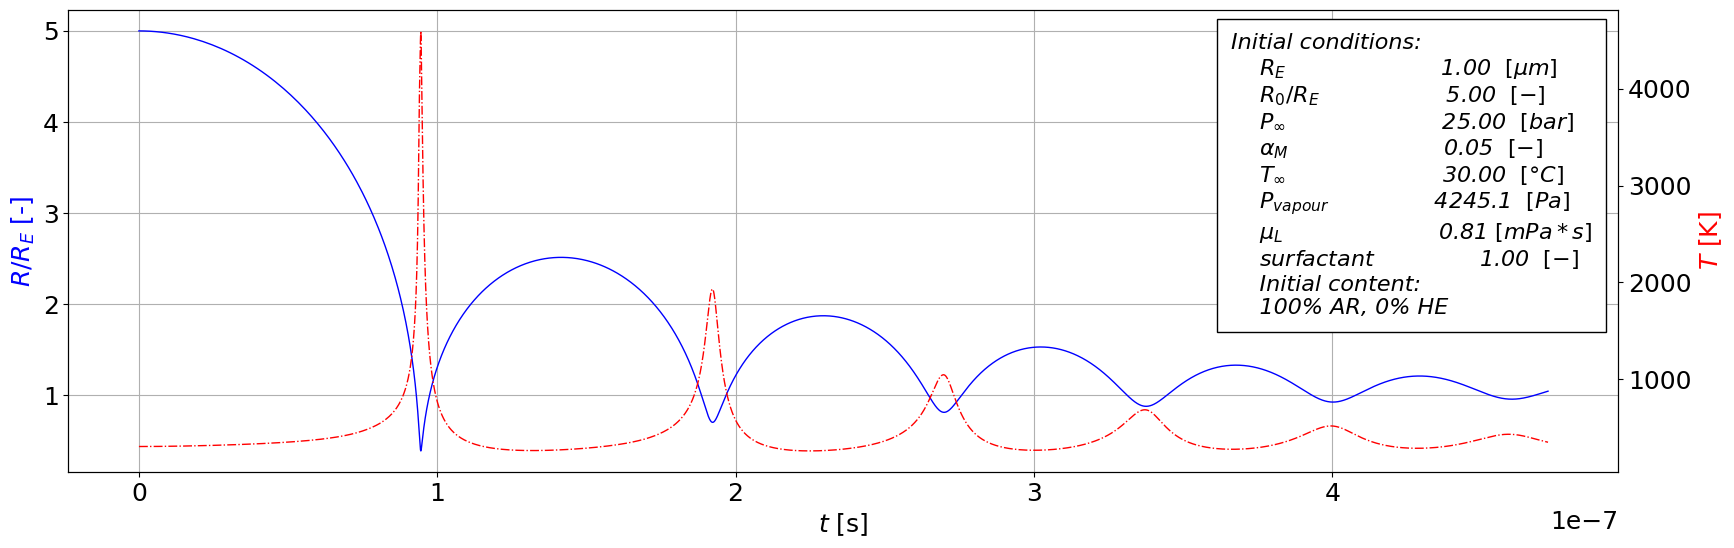

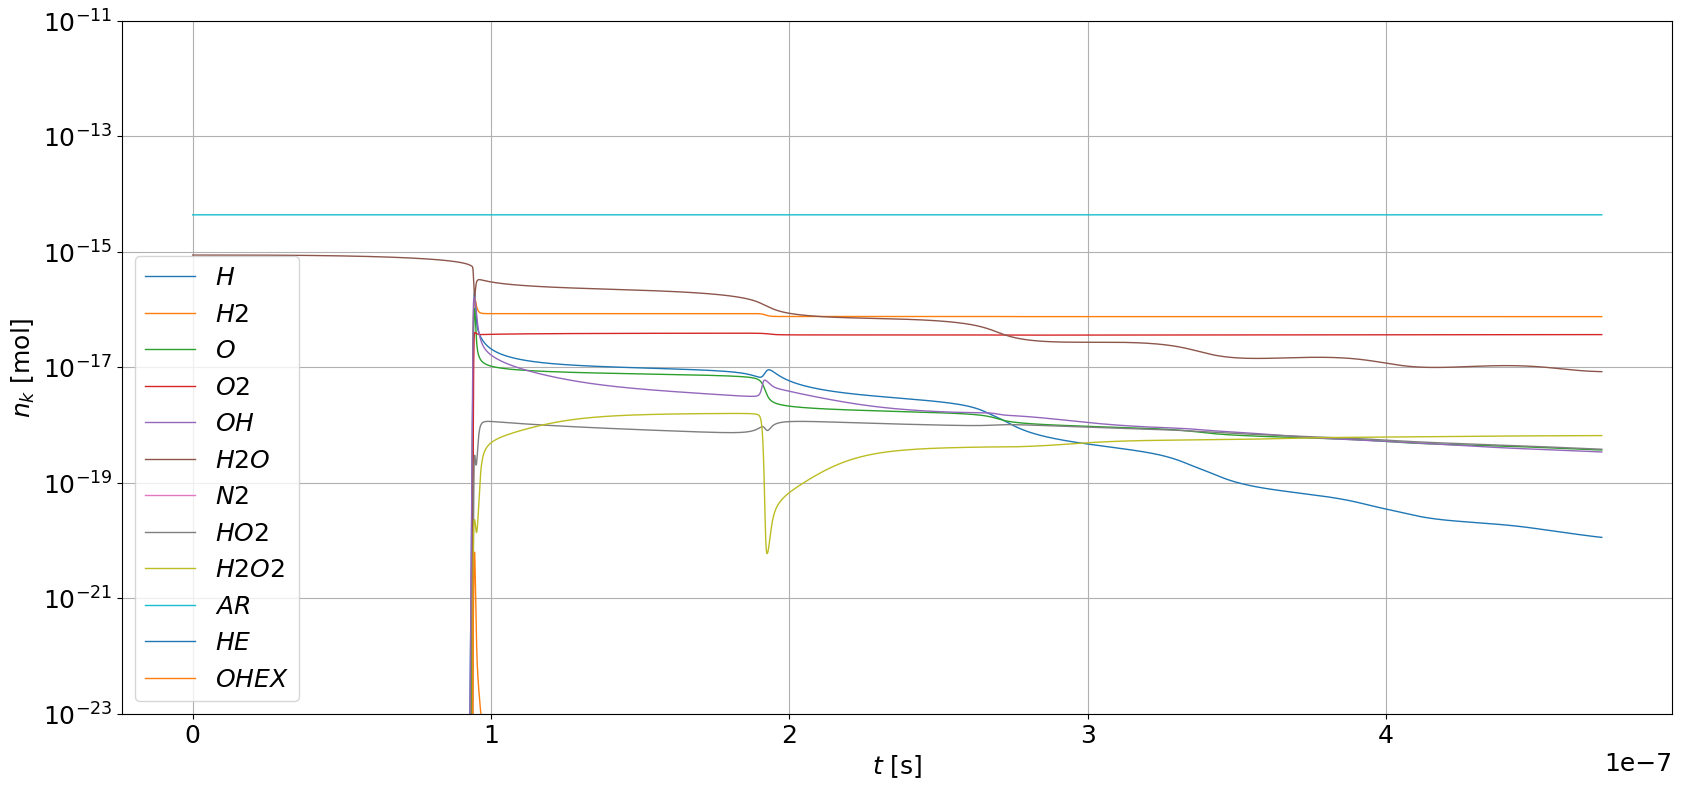

Control parameters:
    ID = 11
    R_E = 1.00 [um]
    ratio = 5.00 [-]
    P_inf = 25.00 [bar]
    alfa_M = 0.05 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 1.00 [-]
    100% AR, 0% HE
Simulation info:
    error_code = 0
    elapsed_time = 0.59 [s]
    steps = 9287 [-]
Final state:
    R_final = 1.01 [um];   R_dot_final =3.254016641812662e-17 [m/s];   T_final = 303.15 [K]
    n_H2 =7.572721889879165e-17 [mol]; n_O2 =3.750034911835342e-17 [mol]
    Final molar concentrations: [mol/cm^3]
        H: -1.548800955260518e-21;  H2: 1.7612484790644613e-05;  O: -1.0955628176528624e-15;  O2: 8.721756035614847e-06;  
        OH: 4.350039873558345e-21;  H2O: 1.6842204457222369e-06;  N2: 0.0;  HO2: -1.913624095339743e-11;  
        H2O2: 1.690014248718123e-07;  AR: 0.0010202800746701973;  HE: 0.0;  OHEX: 1.0451687562484348e-40;  
        
Results:
    collapse_time = 9.448702652653912e-08 [s]
    T_max = 4598.78 [K]
    expansion work = 1.26463836025

In [7]:
"""Plot a certain simulation"""

# converts a line of all_data to a dictionary containing the control parameters (cpar)
def line_to_dict(line):
    gases = str(line['gases'])
    fractions = str(line['fractions'])
    return de.dotdict(dict(
        ID=line['ID'],
        R_E=line['R_E'], # [m]
        ratio=line['ratio'], # [-]
        P_inf=line['P_inf'], # [Pa]
        alfa_M=line['alfa_M'], # [-]
        T_inf=line['T_inf'], # [m]
        surfactant=line['surfactant'], # [-]
        P_v=line['P_v'], # [Pa]
        mu_L=line['mu_L'], # [Pa*s]
        gases=[int(index) for index in gases.split(' ') if index!=''],  # indexes of species in initial bubble
        fractions=[float(frac) for frac in fractions.split(' ') if frac!=''], # molar fractions of species in initial bubble
    ))
    
cpar = line_to_dict(good_data.iloc[1])   # choose the most energy efficient one
de.plot(cpar)